Лабораторна робота №2

з курсу 'Основи технологій машинного навчання'

Класифікація видів об’єктів.

Предментна область: транспорт.

Види: 1)кроссовер; 2)седан; 3)автобус; 4)трамвай;

Виконав: студент групи ТІ-72

Сторожук Костянтин Сергійович

Виконано у сервісі gradient

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [4]:
""" 
this is customized function because new version of Bing Api do not support code from fastai example
@see: https://forums.fast.ai/t/02-production-permissiondenied-error/65823/24
"""
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [5]:
results = search_images_bing('26d547c3cfd54a2cbd99315f40737c5e', 'SUV')
ims = results.attrgot('contentUrl') # in new bing use camelCase
len(ims)

150

In [6]:
results

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=SUV&id=83CB11E4489351528649027F02B61B75D01CEB7C&simid=608041282261483680', 'name': '11 Cheapest SUVs And Crossovers To Own Of 2019', 'thumbnailUrl': 'https://tse3.mm.bing.net/th?id=OIP.vbETgAqc6dBzCKrmUEZKcQHaEK&o=6&pid=Api', 'datePublished': '2020-03-25T18:55:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'https://cdn.motor1.com/images/mgl/ZJNRe/s3/full-size-suv-crossover-nissan-armada.jpg', 'hostPageUrl': 'https://www.motor1.com/features/258453/cheapest-to-own-suvs-crossovers/', 'contentSize': '65342 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'https://www.motor1.com/features/258453/cheapest-to-own-suvs-crossovers', 'width': 1280, 'height': 720, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.6SAr3H8ht3RKlQ1uCLVGsQ&pid=Api', 'hostPageDomainFriendlyName': 'MOTOR1', 'hostPageDiscoveredDate': '2018-08-21T00:00:00.0000000Z', 'thumbnail': {'width': 474, 'height': 266}, 'imageInsig

In [7]:
ims[0]

'https://cdn.motor1.com/images/mgl/ZJNRe/s3/full-size-suv-crossover-nissan-armada.jpg'

In [8]:
dest = 'images/SUV.jpg'
download_url(ims[0], dest)

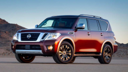

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
transport_types = 'SUV','sedan','bus','tram'
path = Path('transports')

In [11]:
if not path.exists():
    path.mkdir()
    for o in transport_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing('26d547c3cfd54a2cbd99315f40737c5e', f'{o} transport')
        download_images(dest, urls=results.attrgot('contentUrl')) #

In [12]:
fns = get_image_files(path)
fns

(#582) [Path('transports/SUV/00000007.jpg'),Path('transports/SUV/00000002.jpg'),Path('transports/SUV/00000008.jpg'),Path('transports/SUV/00000004.jpg'),Path('transports/SUV/00000001.jpg'),Path('transports/SUV/00000006.jpg'),Path('transports/SUV/00000000.png'),Path('transports/SUV/00000005.jpg'),Path('transports/SUV/00000010.jpg'),Path('transports/SUV/00000012.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

In [15]:
transports = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = transports.dataloaders(path)

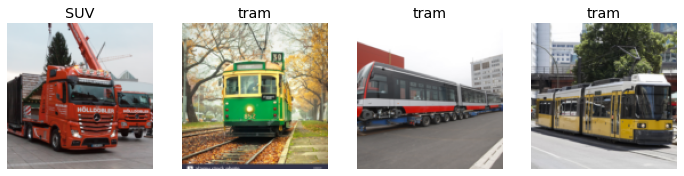

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

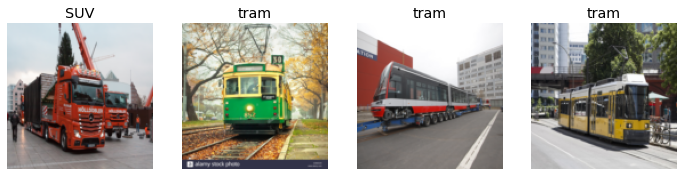

In [18]:
transports = transports.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = transports.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

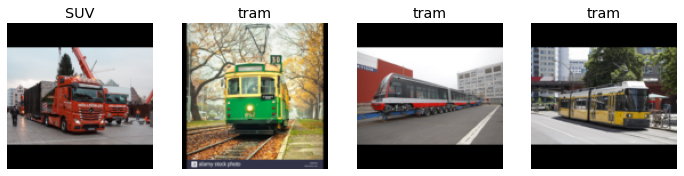

In [19]:
transports = transports.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = transports.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

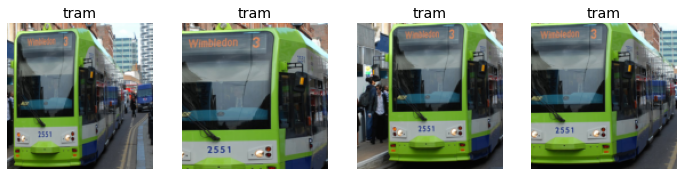

In [20]:
transports = transports.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = transports.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

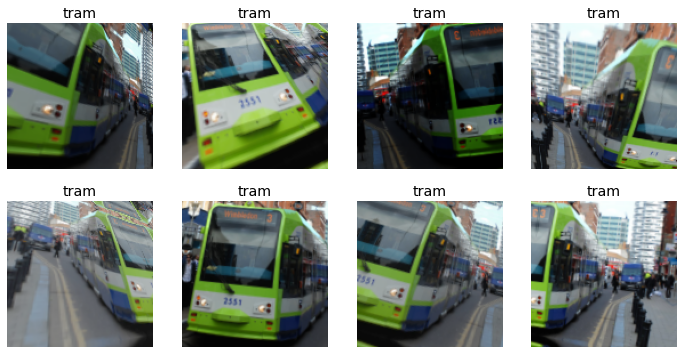

In [21]:
#data augmentation
transports = transports.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = transports.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
# Training Your Model, and Using It to Clean Your Data
transports = transports.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = transports.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.085377,1.487353,0.413793,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.313329,1.117530,0.336207,00:09
1,1.102789,1.018515,0.310345,00:10
2,0.947471,0.929597,0.275862,00:11
3,0.858871,0.892775,0.267241,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

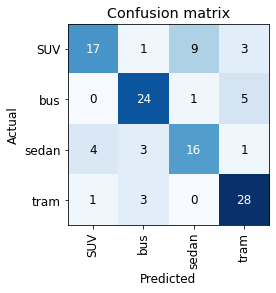

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

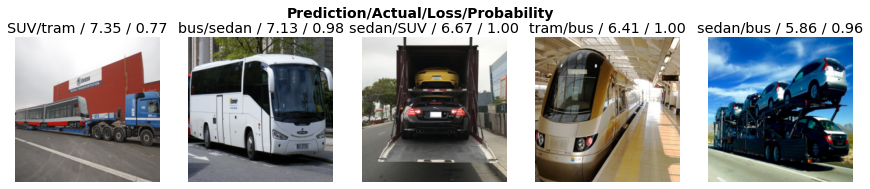

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
# Turning Your Model into an Online Application
# Using the Model for Inference
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('images/SUV.jpg')

('SUV',
 TensorImage(0),
 TensorImage([6.1282e-01, 2.3383e-04, 3.8298e-01, 3.9661e-03]))

In [32]:
# Creating a Notebook App from the Model
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/SUV.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: SUV; Probability: 0.6128')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your transport!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [42]:
#Turning Your Notebook into a Real App

!pip install voila
!jupyter serverextension enable voila --sys-prefix

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK
